## NR - SLD - CNN Prediction

### Install package

In [ ]:
!pip uninstall -y pyreflect

In [ ]:
!pip install -i https://test.pypi.org/simple/ pyreflect==1.1.8

In [ ]:
!pip show pyreflect

In [ ]:
!python -m pyreflect init --force

In [1]:
import pyreflect
from pyreflect.config import load_config
import pyreflect.flows as workflow
from pyreflect.input import NRSLDDataProcessor
import pandas as pd
from pathlib import Path
from pprint import pprint

from typing import List
import numpy as np

/home/qiao.yuqi/.conda/envs/PT_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Selected device for model training: cuda


In [2]:
#load config
root = "./"
# root = Path("./")

config = pyreflect.config.load_config(root)
pprint(config["nr_predict_sld"])

{'file': {'experimental_nr_file': 'data/curves/expt_nr.npy',
          'nr_curves_poly': 'data/curves/nr_curves_poly.npy',
          'reflectivity_model_bounds': 'data/curves/reflectivity_model_bounds.json',
          'sld_curves_poly': 'data/curves/sld_curves_poly.npy'},
 'models': {'batch_size': 32,
            'epochs': 3,
            'model': 'data/curves/trained_nr_sld_model.pth',
            'num_curves': 50000,
            'num_film_layers': 6}}


### Load NR SLD profile before reconstruction

In [3]:
orig_nr_file = "./data/curves/nr_tst_orig.npy"
orig_sld_file = "./data/curves/sld_tst_orig.npy"

orig_dproc = NRSLDDataProcessor(orig_nr_file,orig_sld_file)
orig_nr_arr, orig_sld_arr = orig_dproc.load_data()

#orig saved data is already normalized 
# orig_nr_arr = orig_dproc.normalize_nr()
# orig_sld_arr = orig_dproc.normalize_sld()


In [4]:
import matplotlib.pyplot as plt

def plot_experiment_results(expt_nr_data,expt_sld_data,orig_nr_data=None,predicted_sld=None):
    """
    Plots experimental NR data separately and overlays experimental SLD with predicted SLD if available.

    Parameters:
        expt_nr_data (np.ndarray): Experimental Neutron Reflectivity data, shape (2, *).
        predicted_sld (np.ndarray): Predicted SLD profile, shape (2, *).
        expt_sld_data (np.ndarray, optional): Experimental SLD profile, shape (2, *). Default is None.

    Notes:
        - expt_nr_data[0] is Q (wave vector), expt_nr_data[1] is Reflectivity.
        - predicted_sld[0] is Depth (Å), predicted_sld[1] is SLD values.
        - expt_sld_data is only plotted if provided.
    """

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Two side-by-side plots

    # Left Plot: Experimental NR (Reflectivity vs. Q)
    
    axes[0].plot(expt_nr_data[0], expt_nr_data[1], 'b-', label="AE Denoised NR", alpha=0.7)
    if orig_nr_data is not None:
        axes[0].plot(orig_nr_data[0], orig_nr_data[1], 'g--', label="Original NR", linewidth=2)
    
    axes[0].set_xlabel("Q (1/Å)")  # Wave vector transfer
    axes[0].set_ylabel("Reflectivity", color="blue")
    axes[0].set_yscale("log")  # Reflectivity is usually in log scale
    axes[0].set_title("Experimental NR Data")
    axes[0].legend()

    # Right Plot: Predicted SLD vs. Experimental SLD (if available)
    axes[1].plot(expt_sld_data[0], expt_sld_data[1], 'r-', label="Original SLD", linewidth=2)
    
    if predicted_sld is not None:
        axes[1].plot(predicted_sld[0], predicted_sld[1], 'g--', label="Predicted SLD", linewidth=2)
    
    axes[1].set_xlabel("Depth (Å)")
    axes[1].set_ylabel("Scattering Length Density (SLD) [10⁻⁶ Å⁻²]")
    axes[1].set_title("SLD Profiles")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


### Load Reconstructed NR, SLD profile Data

In [5]:
# Experimental NR data
recon_nr_file = "./data/curves/nr_ae_recon_ldim32.npy"
recon_sld_file = "./data/curves/sld_tst_orig.npy"

# Data processor
data_proc = NRSLDDataProcessor(nr_file_path=recon_nr_file,sld_file_path=recon_sld_file)
recon_nr_arr, recon_sld_arr = data_proc.load_data()

# recon_nr_arr = data_proc.normalize_nr()
# recon_sld_arr = data_proc.normalize_sld()

x_tr, y_tr, x_val,y_val, x_tst, y_tst = data_proc.split_arrays(recon_nr_arr,recon_sld_arr,size_split=0.8)

x_tr.shape, y_tr.shape

((12000, 2, 308), (12000, 2, 900))

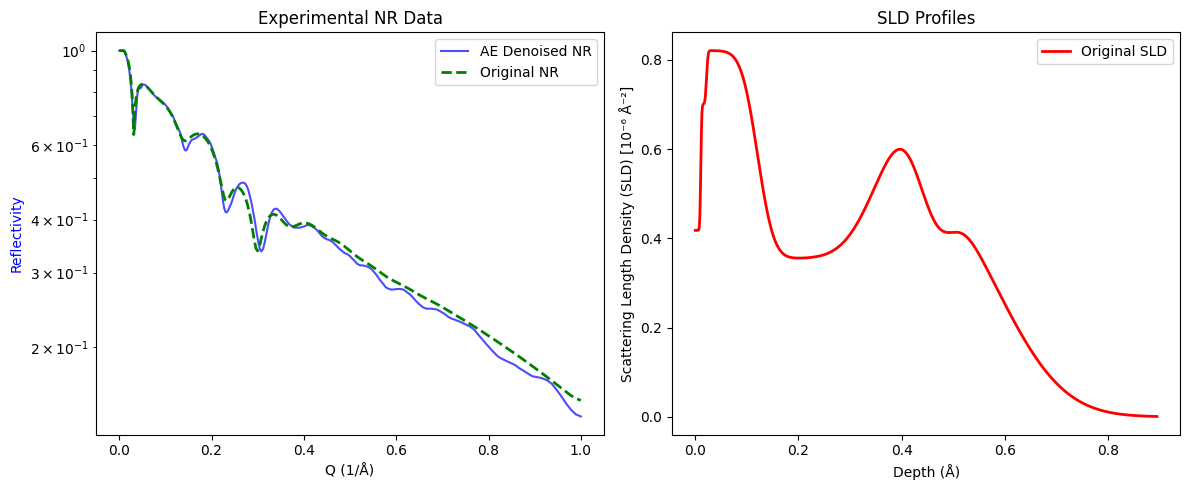

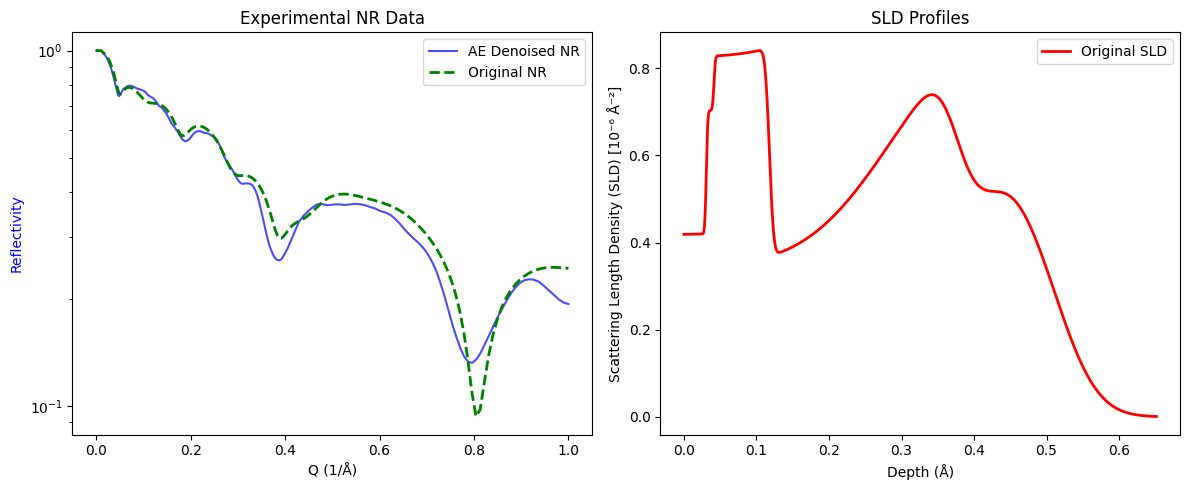

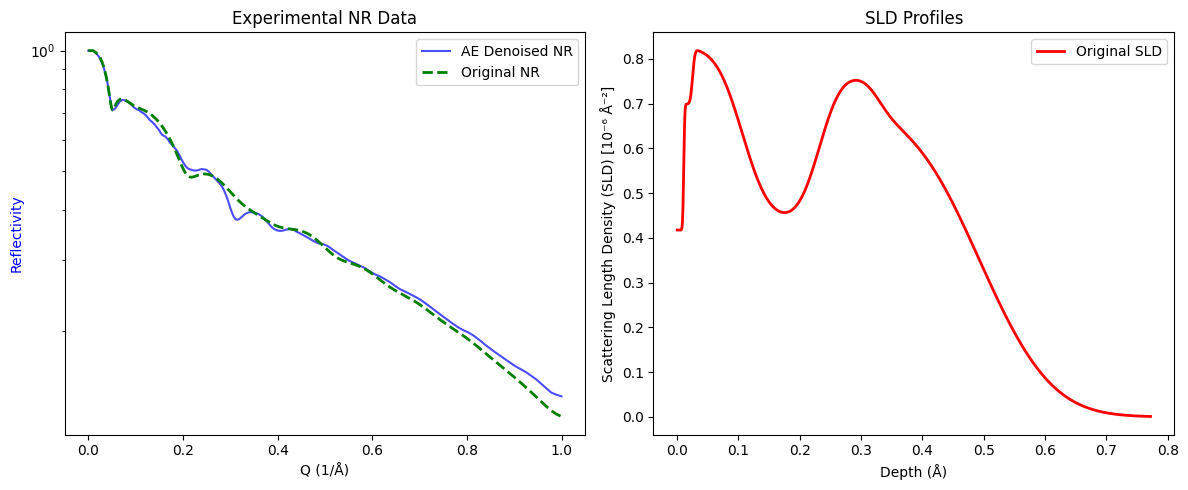

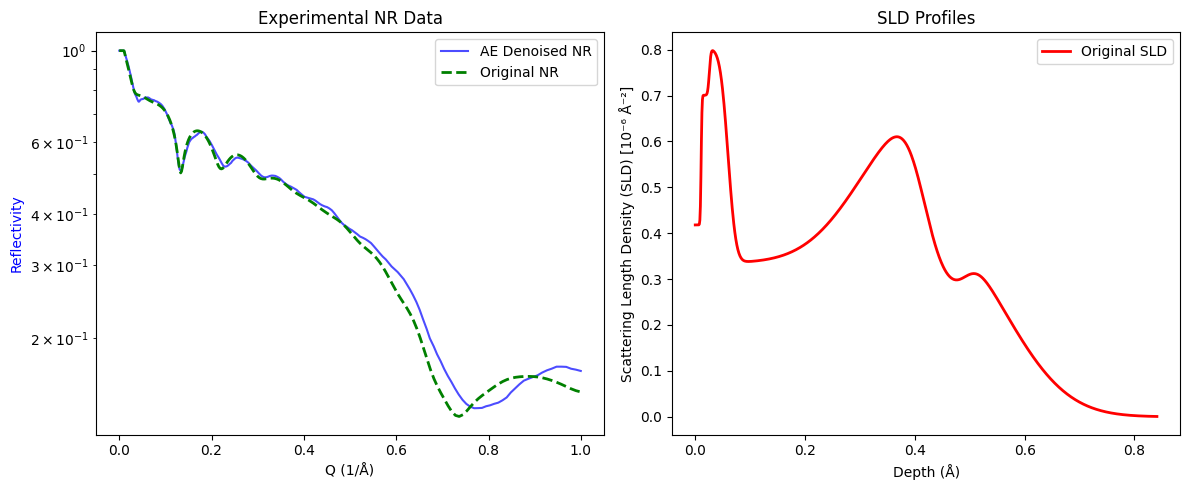

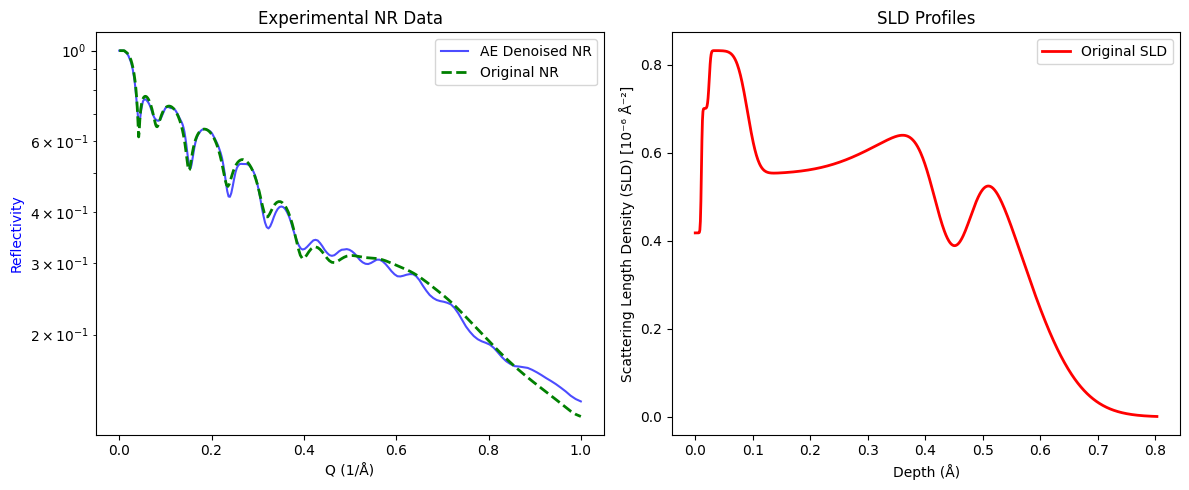

In [6]:
for nr, sld,orig_nr in zip(recon_nr_arr[:5],recon_sld_arr[:5],orig_nr_arr[:5]):
    plot_experiment_results(nr,sld,orig_nr)

### Model Training and Prediction

In [7]:
from pyreflect.models.config import NRSLDModelTrainerParams
from pyreflect.flows.nr_predict_sld import train_nr_predict_sld_model,predict_sld_from_nr

file_config = config["nr_predict_sld"]["file"]
model_config = config["nr_predict_sld"]["models"]

In [8]:
nr_cnn_train_file = "data/curves/nr_cnn_train.npy"
sld_cnn_train_file = "data/curves/sld_cnn_train.npy"

nr_cnn_test_file = "data/curves/nr_cnn_test.npy"
sld_cnn_test_file = "data/curves/sld_cnn_test.npy"

np.save(nr_cnn_train_file,x_tr)
np.save(sld_cnn_train_file,y_tr)
np.save(nr_cnn_test_file,x_tst)
np.save(sld_cnn_test_file,y_tst)

In [12]:
#use AE reconstructed NR SLD to train model
file_config["nr_curves_poly"] = nr_cnn_train_file
file_config["sld_curves_poly"] = sld_cnn_train_file #corresponding sld
model_config["epochs"]= 10
model_config["num_film_layers"]=6
config["root"] = "./"
file_config, model_config

({'experimental_nr_file': 'data/curves/expt_nr.npy',
  'nr_curves_poly': 'data/curves/nr_cnn_train.npy',
  'sld_curves_poly': 'data/curves/sld_cnn_train.npy',
  'reflectivity_model_bounds': 'data/curves/reflectivity_model_bounds.json'},
 {'model': 'data/curves/trained_nr_sld_model.pth',
  'num_film_layers': 6,
  'num_curves': 50000,
  'epochs': 10,
  'batch_size': 32})

In [13]:
trainer_params = NRSLDModelTrainerParams(root,_config = config)

model = train_nr_predict_sld_model(trainer_params,auto_save=True)

Epoch 1/10 - Train Loss: 0.010915, Validation Loss: 0.008311
Epoch 2/10 - Train Loss: 0.008136, Validation Loss: 0.007984
Epoch 3/10 - Train Loss: 0.007628, Validation Loss: 0.006948
Epoch 4/10 - Train Loss: 0.007069, Validation Loss: 0.007810
Epoch 5/10 - Train Loss: 0.006435, Validation Loss: 0.006122
Epoch 6/10 - Train Loss: 0.005895, Validation Loss: 0.005663
Epoch 7/10 - Train Loss: 0.005466, Validation Loss: 0.005354
Epoch 8/10 - Train Loss: 0.005245, Validation Loss: 0.004898
Epoch 9/10 - Train Loss: 0.005141, Validation Loss: 0.005090
Epoch 10/10 - Train Loss: 0.005021, Validation Loss: 0.004689
NR predict SLD trained CNN model saved at: data/curves/trained_nr_sld_model.pth


In [ ]:
# model = load_nr_sld_model(model_config["model"])

In [14]:
y_pred = predict_sld_from_nr(model, nr_cnn_test_file)

Predicted SLD shape: (1500, 2, 900)


### Plotting check
 - AE Latent dim: 16

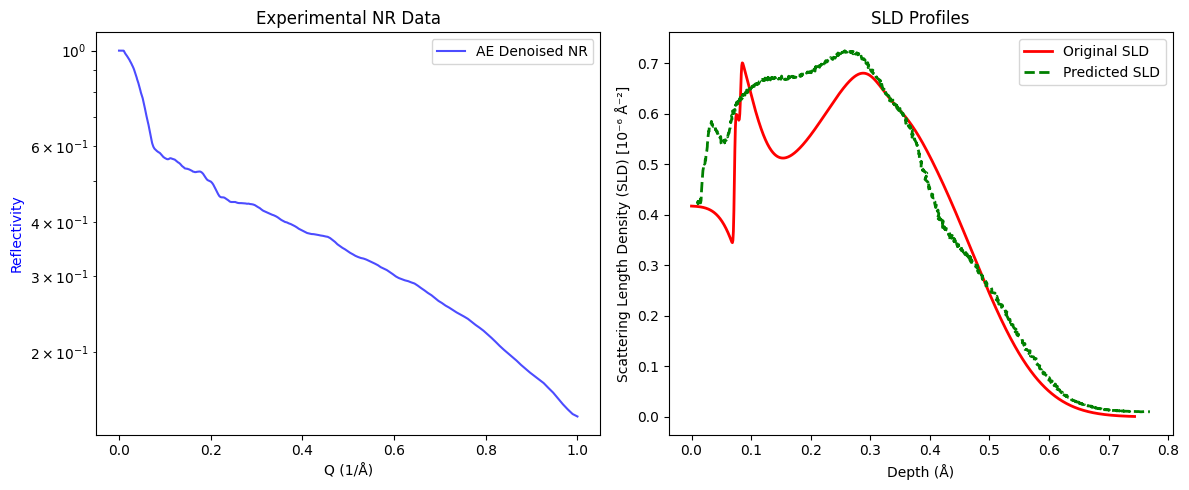

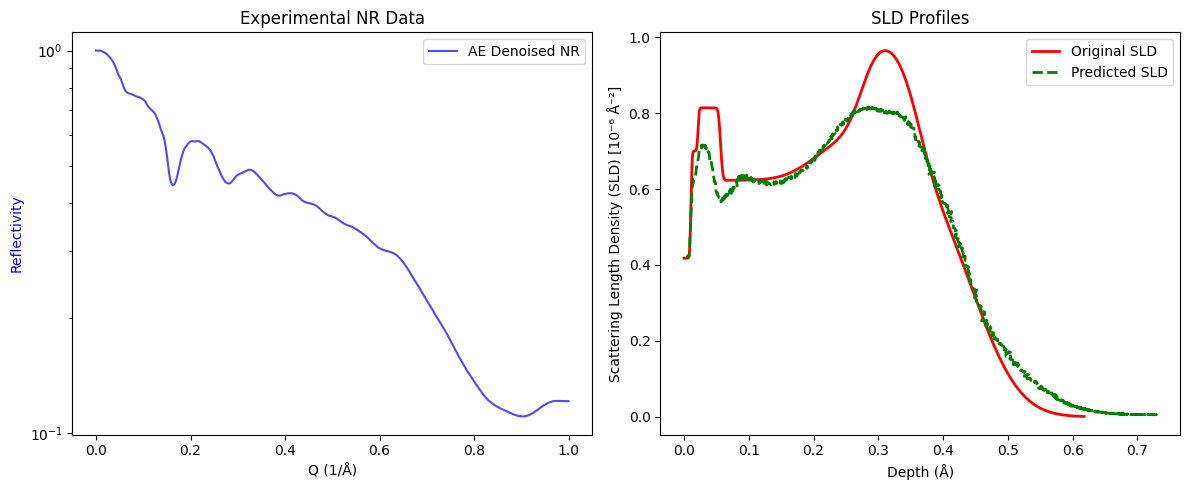

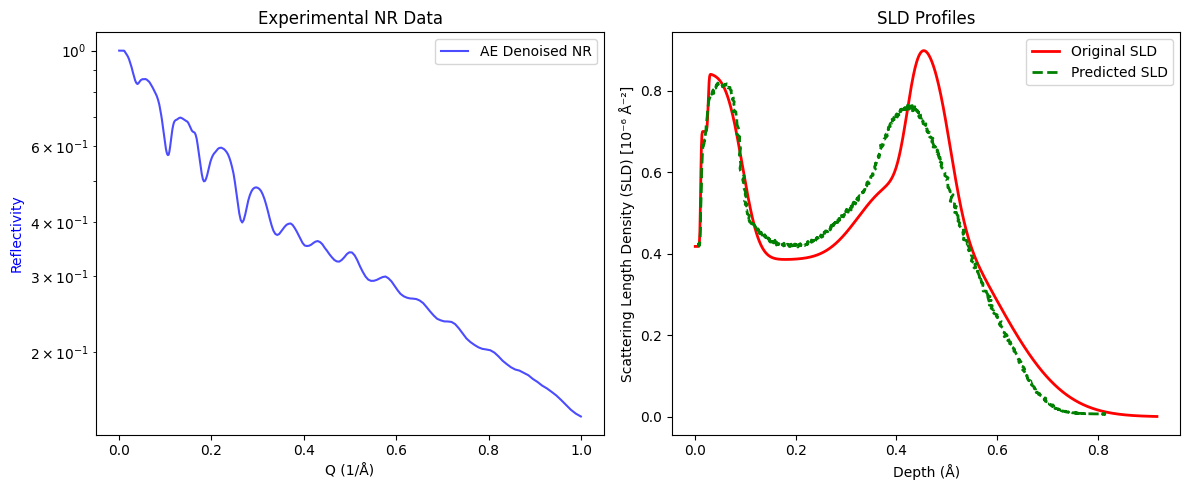

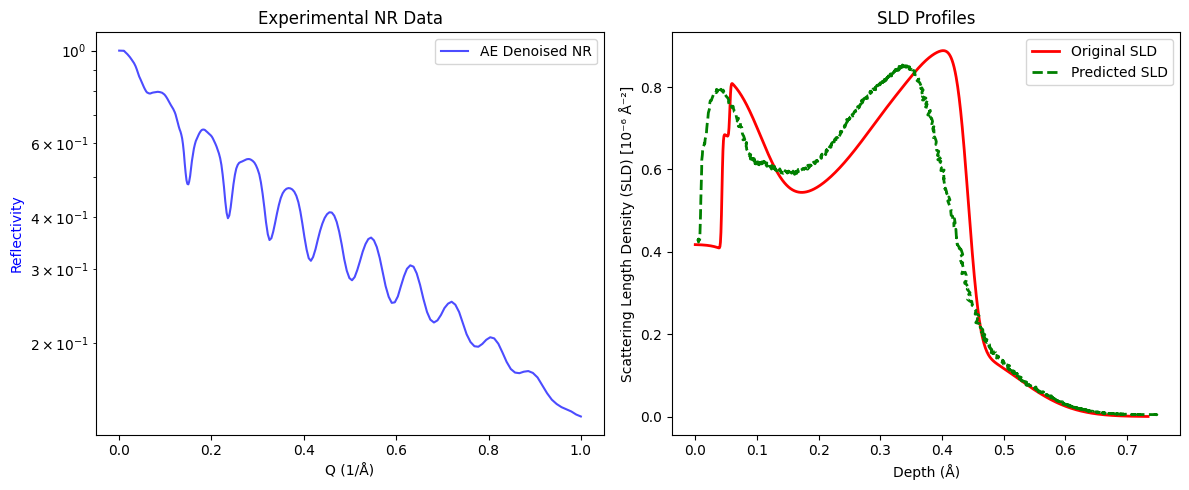

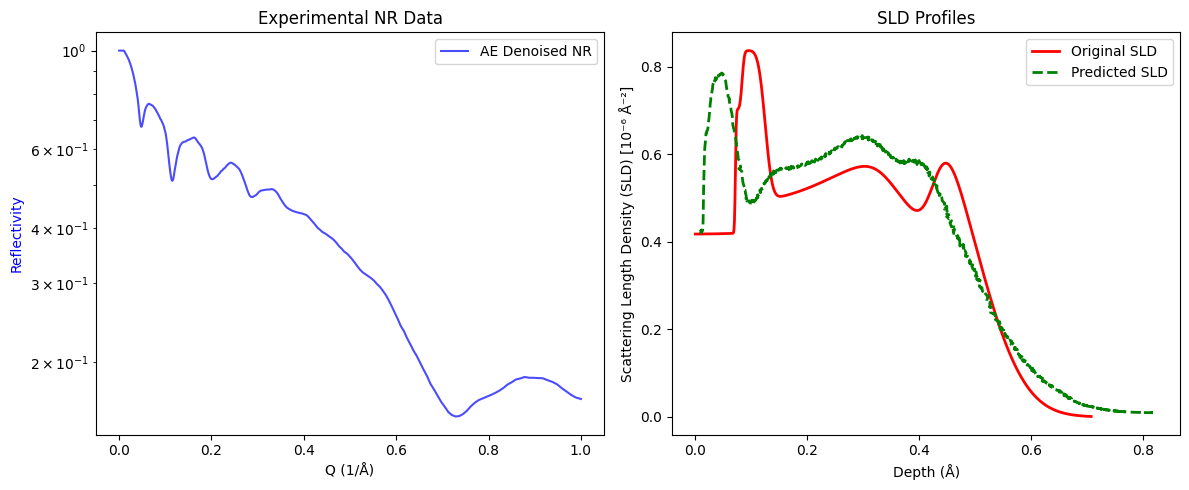

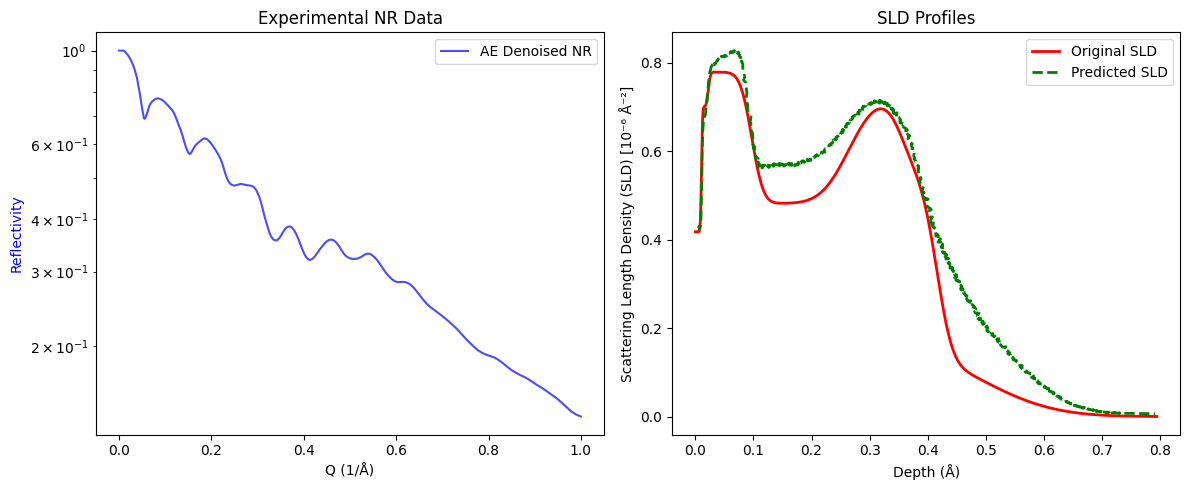

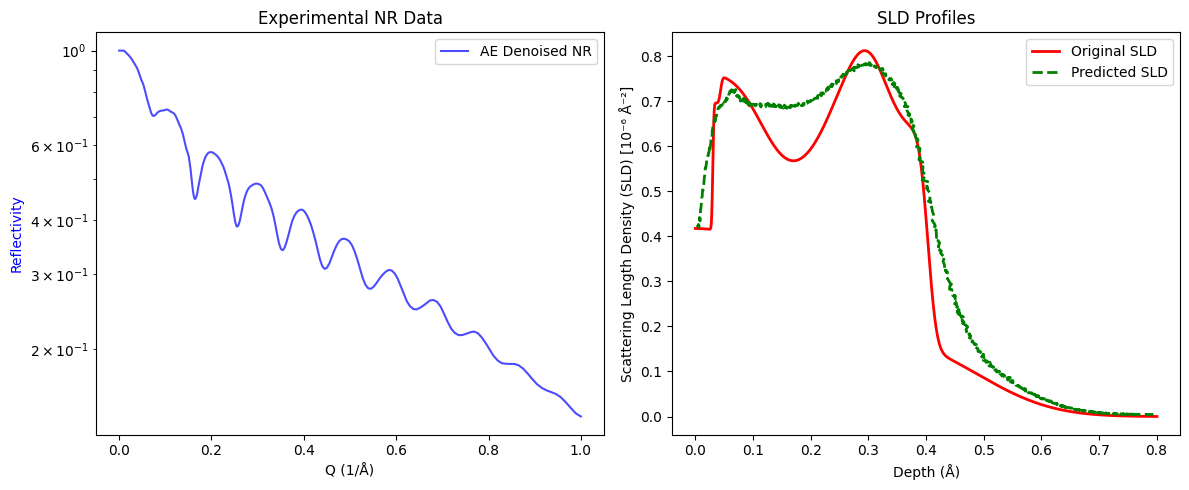

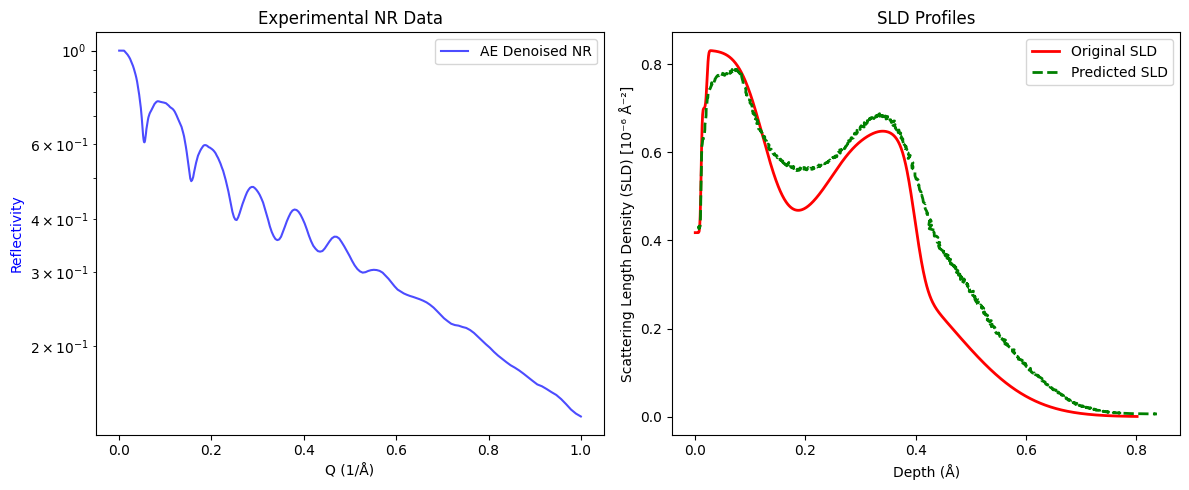

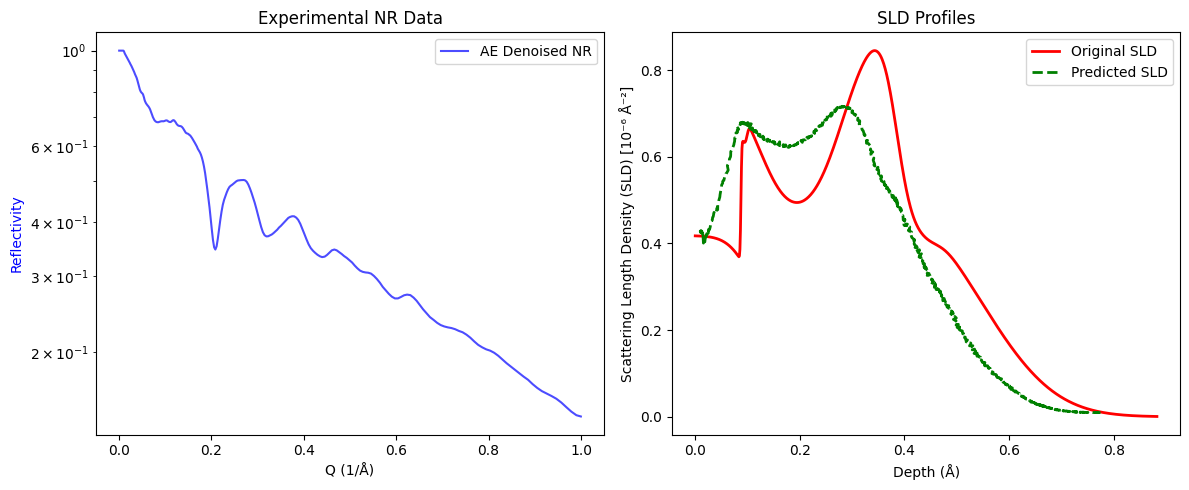

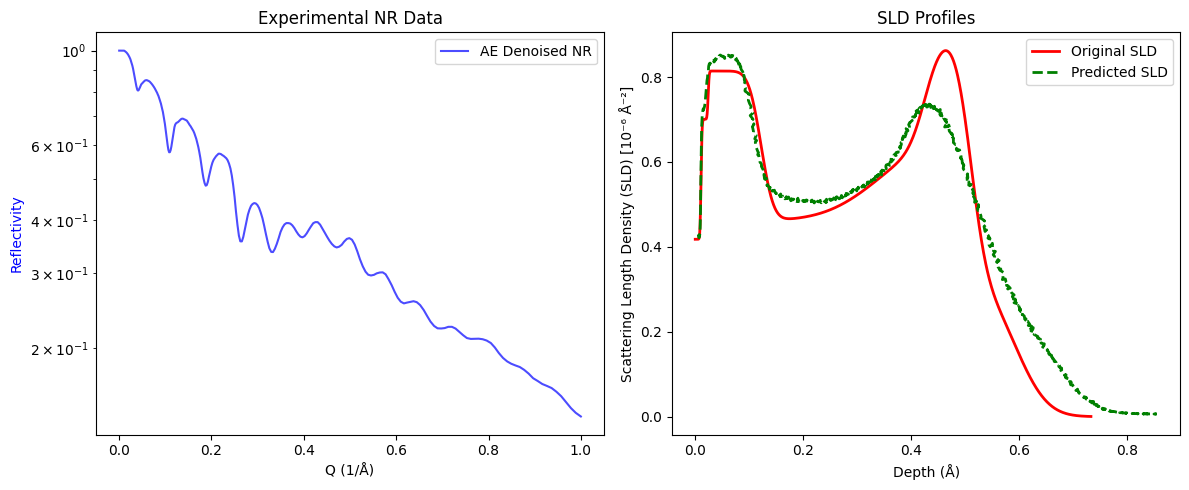

In [15]:
for recon_nr, sld, y_pred in zip(x_tst[:10], y_tst[:10], y_pred[:10]):
    plot_experiment_results(recon_nr,sld,predicted_sld=y_pred)
